# Picking an integrator

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.jplhorizons import Horizons

from jorbit import System, Particle, Observations

In [2]:
nights = [Time("2025-01-01 07:00"), Time("2025-01-02 07:00"), Time("2025-01-05 07:00")]

times = []
for n in nights:
    times.extend([n + i * 1 * u.hour for i in range(3)])
times = Time(times)

obj = Horizons(id="274301", location="695@399", epochs=times.utc.jd)
pts = obj.ephemerides(extra_precision=True, quantities="1")

coords = SkyCoord(pts["RA"], pts["DEC"], unit=(u.deg, u.deg))
times = Time(pts["datetime_jd"], format="jd", scale="utc")

obs = Observations(
    observed_coordinates=coords,
    times=times,
    observatories="kitt peak",
    astrometric_uncertainties=1 * u.arcsec,
)

In [3]:
obj = Horizons(id="274301", location="500@0", epochs=times.tdb.jd[0])
vecs = obj.vectors(refplane="earth")
true_x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
true_v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]


p_true = Particle(
    x=true_x0, v=true_v0, time=times[0], name="274301 Wikipedia", observations=obs,
)

p_perturbed = Particle(
    x=true_x0 + jnp.ones(3) * 1e-1,
    v=true_v0 - jnp.ones(3) * 1e-3,
    time=times[0],
    name="274301 Perturbed",
    observations=obs,
    integrator="Y4",
    max_step_size=1 * u.day,
    gravity="newtonian planets",
)

In [4]:
p_best_fit = p_perturbed.max_likelihood(verbose=True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =          100

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07889D+02    |proj g|=  5.53857D+06

At iterate    1    f=  2.31464D+02    |proj g|=  3.66558D+06

At iterate    2    f=  1.87597D+02    |proj g|=  3.28397D+06

At iterate    3    f=  1.65411D+01    |proj g|=  6.59662D+03

At iterate    4    f=  1.65411D+01    |proj g|=  1.02985D+01

At iterate    5    f=  1.65411D+01    |proj g|=  6.98029D+00


 This problem is unconstrained.



At iterate    6    f=  1.65411D+01    |proj g|=  7.31661D+00

At iterate    7    f=  1.65411D+01    |proj g|=  2.20100D+01

At iterate    8    f=  1.65411D+01    |proj g|=  3.61872D+01

At iterate    9    f=  1.65411D+01    |proj g|=  5.17017D+01

At iterate   10    f=  1.65411D+01    |proj g|=  6.48864D+01

At iterate   11    f=  1.65411D+01    |proj g|=  8.89030D+01

At iterate   12    f=  1.65411D+01    |proj g|=  1.30412D+02

At iterate   13    f=  1.65411D+01    |proj g|=  1.95206D+02

At iterate   14    f=  1.65411D+01    |proj g|=  3.00378D+02

At iterate   15    f=  1.65411D+01    |proj g|=  4.67590D+02

At iterate   16    f=  1.65411D+01    |proj g|=  7.28398D+02

At iterate   17    f=  1.65411D+01    |proj g|=  1.10779D+03

At iterate   18    f=  1.65410D+01    |proj g|=  1.56400D+03

At iterate   19    f=  1.65410D+01    |proj g|=  1.83716D+03

At iterate   20    f=  1.65409D+01    |proj g|=  1.40197D+03

At iterate   21    f=  1.65409D+01    |proj g|=  7.67465D+02

At iter

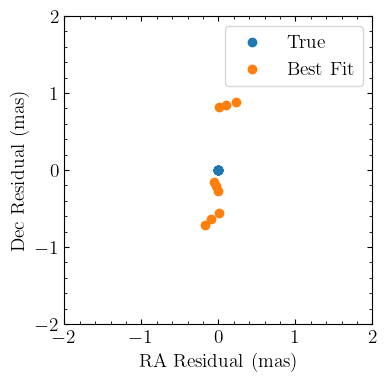

In [5]:
res_true = p_true.residuals(p_true._keplerian_state)
res_perturbed = p_perturbed.residuals(p_perturbed._keplerian_state)
res_best_fit = p_best_fit.residuals(p_best_fit._keplerian_state)

fig, ax = plt.subplots()
ax.scatter(res_true[:, 0] * 1e3, res_true[:, 1] * 1e3, label="True")
ax.scatter(res_best_fit[:, 0] * 1e3, res_best_fit[:, 1] * 1e3, label="Best Fit")
w = 2
ax.set(
    xlim=(-w, w),
    ylim=(-w, w),
    aspect="equal",
    xlabel="RA Residual (mas)",
    ylabel="Dec Residual (mas)",
)
ax.legend()

In [6]:
obj = Horizons(id="274301", location="500@0", epochs=times.tdb.jd[0])
vecs = obj.vectors(refplane="earth")
true_x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
true_v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]


p_true = Particle(
    x=true_x0, v=true_v0, time=times[0], name="274301 Wikipedia", observations=obs,
)

p_perturbed = Particle(
    x=true_x0 + jnp.ones(3) * 1e-1,
    v=true_v0 - jnp.ones(3) * 1e-3,
    time=times[0],
    name="274301 Perturbed",
    observations=obs,
    integrator="ias15",
    gravity="newtonian planets",
)

In [7]:
p_best_fit = p_perturbed.max_likelihood(verbose=True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =          100

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07889D+02    |proj g|=  5.53857D+06

At iterate    1    f=  2.31464D+02    |proj g|=  3.66558D+06

At iterate    2    f=  1.87597D+02    |proj g|=  3.28397D+06

At iterate    3    f=  1.65411D+01    |proj g|=  6.61692D+03


 This problem is unconstrained.



At iterate    4    f=  1.65411D+01    |proj g|=  9.72384D+00

At iterate    5    f=  1.65411D+01    |proj g|=  6.97909D+00

At iterate    6    f=  1.65411D+01    |proj g|=  6.69906D+00

At iterate    7    f=  1.65411D+01    |proj g|=  2.21695D+01

At iterate    8    f=  1.65411D+01    |proj g|=  3.51830D+01

At iterate    9    f=  1.65411D+01    |proj g|=  5.06121D+01

At iterate   10    f=  1.65411D+01    |proj g|=  6.97157D+01

At iterate   11    f=  1.65411D+01    |proj g|=  1.02954D+02

At iterate   12    f=  1.65411D+01    |proj g|=  1.56902D+02

At iterate   13    f=  1.65411D+01    |proj g|=  2.43899D+02

At iterate   14    f=  1.65411D+01    |proj g|=  3.81497D+02

At iterate   15    f=  1.65411D+01    |proj g|=  6.01340D+02

At iterate   16    f=  1.65411D+01    |proj g|=  9.31490D+02

At iterate   17    f=  1.65410D+01    |proj g|=  1.37525D+03

At iterate   18    f=  1.65410D+01    |proj g|=  1.78589D+03

At iterate   19    f=  1.65409D+01    |proj g|=  1.72840D+03

At iter

In [8]:
obj = Horizons(id="274301", location="500@0", epochs=times.tdb.jd[0])
vecs = obj.vectors(refplane="earth")
true_x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
true_v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]


p_true = Particle(
    x=true_x0, v=true_v0, time=times[0], name="274301 Wikipedia", observations=obs,
)

p_perturbed = Particle(
    x=true_x0 + jnp.ones(3) * 1e-1,
    v=true_v0 - jnp.ones(3) * 1e-3,
    time=times[0],
    name="274301 Perturbed",
    observations=obs,
    integrator="ias15",
    gravity="default solar system",
)

In [9]:
p_best_fit = p_perturbed.max_likelihood(verbose=True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =          100

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07889D+02    |proj g|=  5.53857D+06


 This problem is unconstrained.



At iterate    1    f=  2.31464D+02    |proj g|=  3.66558D+06

At iterate    2    f=  1.87597D+02    |proj g|=  3.28397D+06

At iterate    3    f=  1.65411D+01    |proj g|=  6.58754D+03

At iterate    4    f=  1.65411D+01    |proj g|=  1.15692D+01

At iterate    5    f=  1.65411D+01    |proj g|=  6.97981D+00

At iterate    6    f=  1.65411D+01    |proj g|=  7.57064D+00

At iterate    7    f=  1.65411D+01    |proj g|=  2.20069D+01

At iterate    8    f=  1.65411D+01    |proj g|=  3.73087D+01

At iterate    9    f=  1.65411D+01    |proj g|=  5.48952D+01

At iterate   10    f=  1.65411D+01    |proj g|=  6.55449D+01

At iterate   11    f=  1.65411D+01    |proj g|=  8.32806D+01

At iterate   12    f=  1.65411D+01    |proj g|=  1.18066D+02

At iterate   13    f=  1.65411D+01    |proj g|=  1.69354D+02

At iterate   14    f=  1.65411D+01    |proj g|=  2.54802D+02

At iterate   15    f=  1.65411D+01    |proj g|=  3.91361D+02

At iterate   16    f=  1.65411D+01    |proj g|=  6.05992D+02

At iter

In [6]:
p1 = Particle.from_horizons(
    name="274301",
    time=Time("2026-01-01"),
    integrator="Y4",
    max_step_size=1 * u.day,
    gravity="newtonian planets",
)

p2 = Particle.from_horizons(
    name="274301",
    time=Time("2026-01-01"),
    integrator="ias15",
    gravity="newtonian planets",
)

ts = Time("2026-01-01") + jnp.arange(0, 365*3, 10)*u.day
eph1 = p1.ephemeris(times=ts, observer="kitt peak")
eph2 = p2.ephemeris(times=ts, observer="kitt peak")

In [7]:
eph1.separation(eph2)

<Angle [0.00000000e+00, 5.52172346e-11, 1.22276081e-10, 2.05498888e-10,
        3.10238783e-10, 4.42779540e-10, 6.10919626e-10, 8.23854632e-10,
        1.09226058e-09, 1.42792945e-09, 1.90924115e-09, 2.50119738e-09,
        3.21011629e-09, 4.02593375e-09, 4.90995775e-09, 5.78781135e-09,
        6.55962680e-09, 7.12777561e-09, 7.44311786e-09, 7.52559596e-09,
        7.44958018e-09, 7.31347045e-09, 7.20221872e-09, 7.17856967e-09,
        7.28301938e-09, 7.53457341e-09, 7.94316788e-09, 8.51068024e-09,
        9.23289206e-09, 1.00131169e-08, 1.09530702e-08, 1.20406735e-08,
        1.32673991e-08, 1.46235532e-08, 1.60994358e-08, 1.76888559e-08,
        1.93831685e-08, 2.11744792e-08, 2.30578259e-08, 2.50256953e-08,
        2.70719152e-08, 2.91930965e-08, 3.13833989e-08, 3.36393885e-08,
        3.59604830e-08, 3.83439023e-08, 4.08532833e-08, 4.34304165e-08,
        4.60803513e-08, 4.88136466e-08, 5.16446980e-08, 5.45865424e-08,
        5.76611141e-08, 6.08949516e-08, 6.43163257e-08, 6.796713

In [17]:
%timeit p1.ephemeris(times=ts, observer="kitt peak")

1.2 s ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit p2.ephemeris(times=ts, observer="kitt peak")

1.15 s ± 8.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
p_best_fit = p_perturbed.max_likelihood(verbose=True)

AttributeError: DynamicJaxprTracer has no attribute to_system

In [ ]:
# obj = Horizons(id="274301", location="500@0", epochs=times.tdb.jd[0])
# vecs = obj.vectors(refplane="earth")
# true_x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
# true_v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]


# p_true = Particle(
#     x=true_x0, v=true_v0, time=times[0], name="274301 Wikipedia", observations=obs
# )

# p_perturbed = Particle(
#     x=true_x0 + jnp.ones(3) * 1e-1,
#     v=true_v0 - jnp.ones(3) * 1e-3,
#     time=times[0],
#     name="274301 Perturbed",
#     observations=obs,
# )